+ 
# Machine Learning Final Project 

### Ben Cohen - 208464487
### Dolev Mishali - 206603060

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore') #ignores overflow on high exponents.

In [2]:
Data = pd.read_csv("data.csv")
## Shows Full table instead of partial one, used for debugging (mostly).
pd.set_option("display.max_rows", None)

**<u>The data description - as it was given to us<u>**

**PassengerId**  - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
    
**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount of money the passenger has paid at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.

**PassengerId** - Id for each passenger in the test set.

**Transported** - The target. For each passenger, predict either True or False.


## Part A:

### 6:

In [3]:
# Transforming non-numerical fields to numerical fields.

#Cabin = We have made 3 new columns splitting Cabin into new columns that we could use their data properlly.
Data["Transported"] = Data["Transported"].astype(int)
#VIP = People with an unknown VIP status assumed to NOT be vip.
Data["VIP"] = Data["VIP"].fillna(0)
Data["VIP"] = Data["VIP"].astype(int)

#Ship activities with unknown tabs assumed to 0
Data["RoomService"] = Data["RoomService"].fillna(0)
Data["Spa"] = Data["Spa"].fillna(0)
Data["ShoppingMall"] = Data["ShoppingMall"].fillna(0)
Data["VRDeck"] = Data["VRDeck"].fillna(0)
Data["FoodCourt"] = Data["FoodCourt"].fillna(0)

#Filling Unknown Ages as the median of the known passengers' ages
Data["Age"] = Data["Age"].fillna((Data["Age"]).median())

#The age group of a person has a great impact on surviving chance, so we have added a column that will tell me if -
#- Passenger is an adult or not.
Data["Adult"] = Data["Age"] >= 18
Data["Adult"] = Data["Adult"].astype(int)

#We mapped the Deck as below Cabin-> Deck,Cabin Num,Side:
Data[["Deck", "Cabin Number", "Side"]] = Data["Cabin"].str.split("/", expand=True) 
#We mapped the PassengerID as below PassengerID-> # in group, group:
Data[["Group", "Number in Group"]] = Data["PassengerId"].str.split("_", expand=True)
Deck_Map = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}  
Data["Deck"] = Data["Deck"].fillna(0)
Data["Deck"] = Data["Deck"].map(Deck_Map)

#We have added a column named "People in Group" - this column hold the amount of people that belong to the same group. 
#People traveling alone / in a group is something that can affect their survival chance.
Data["People In Group"] = Data.groupby("Group")["Group"].transform("count")

#Cabin->Side Categories:
Side_Map = {"P": 1, "S": 2} 
Data["Side"] = Data["Side"].map(Side_Map)

#Dropping fields that will not give us any helpful information:
try:
    Data = Data.drop('Cabin', axis=1)
    Data = Data.drop('Name', axis=1)
    Data = Data.drop('PassengerId', axis=1)
    Data = Data.drop('Group' ,axis=1)
    Data = Data.drop('Number in Group' ,axis=1)
    Data = Data.drop('HomePlanet' ,axis=1)
    Data = Data.drop('Destination' ,axis=1)
except KeyError:
    print("Error: Field does not exist") 
    
# While filling nulls in "CryoSleep" - if a person has a bill in an activity outside his room, meaning he could not be in the room.
#Therefore, if a person has no bills in any activity and his CryoSleep field is null , it means he probablly is in CryoSleep.
cond = (Data["RoomService"]==0) & (Data["Spa"]==0) & (Data["ShoppingMall"]==0) & (Data["VRDeck"]==0) & (Data["FoodCourt"]==0)    
for i in np.where(Data["CryoSleep"].isna() == True)[0]:
    Data.loc[i, "CryoSleep"] = int(cond[i])
Data["CryoSleep"] = Data["CryoSleep"].astype(int)

#People that has no Cabin info (Cabin = NaN) can't give us their location on the ship, therefore give us no additional information.
#We decided to drop those people.
Data.dropna(subset=["Deck", "Cabin Number", "Side"], axis=0 , inplace=True)
Data["Cabin Number"] = Data["Cabin Number"].astype(int)

In [4]:
Data

CryoSleep   Age  VIP  RoomService  FoodCourt  ShoppingMall      Spa  \
0             0  39.0    0          0.0        0.0           0.0      0.0   
1             0  24.0    0        109.0        9.0          25.0    549.0   
2             0  58.0    1         43.0     3576.0           0.0   6715.0   
3             0  33.0    0          0.0     1283.0         371.0   3329.0   
4             0  16.0    0        303.0       70.0         151.0    565.0   
5             0  44.0    0          0.0      483.0           0.0    291.0   
6             0  26.0    0         42.0     1539.0           3.0      0.0   
7             1  28.0    0          0.0        0.0           0.0      0.0   
8             0  35.0    0          0.0      785.0          17.0    216.0   
9             1  14.0    0          0.0        0.0           0.0      0.0   
10            1  34.0    0          0.0        0.0           0.0      0.0   
11            0  45.0    0         39.0     7295.0         589.0    110.0   
12            0  32.0    0         73.0        0.0        1123.0      0.0   
13            0  48.0    0        719.0        1.0          65.0      0.0   
14            0  28.0    0          8.0      974.0          12.0      2.0   
16            0  27.0    0       1286.0      122.0           0.0      0.0   
17            0  24.0    0          0.0        1.0           0.0      0.0   
18            1  45.0    0          0.0        0.0           0.0      0.0   
19            0   0.0    0          0.0        0.0           0.0      0.0   
20            0  14.0    0        412.0        0.0           1.0      0.0   
21            1   1.0    0          0.0        0.0           0.0      0.0   
22            1  49.0    0          0.0        0.0           0.0      0.0   
23            1  29.0    0          0.0        0.0           0.0      0.0   
24            0  10.0    0          0.0        0.0           0.0      0.0   
25            1   1.0    0          0.0        0.0           0.0      0.0   
26            0   7.0    0          0.0        0.0           0.0      0.0   
27            0  21.0    0        980.0        2.0          69.0      0.0   
28            1  62.0    0          0.0        0.0           0.0      0.0   
29            0  15.0    0          0.0      225.0           0.0    998.0   
30            0  34.0    0         22.0     6073.0           0.0   1438.0   
31            0  43.0    0       1125.0        0.0         136.0     48.0   
32            0  32.0    0          0.0      850.0          81.0    437.0   
33            0  47.0    0        214.0        0.0        1411.0      0.0   
34            0   2.0    0          0.0        0.0           0.0      0.0   
35            0  20.0    0          0.0        0.0        1750.0    990.0   
36            1  28.0    0          0.0        0.0           0.0      0.0   
37            0  23.0    0        784.0      964.0           0.0    951.0   
38            0  15.0    0          0.0      492.0          48.0     20.0   
39            0  20.0    0        554.0      195.0           0.0   2606.0   
40            1  30.0    0          0.0        0.0           0.0      0.0   
41            1  17.0    0          0.0        0.0           0.0      0.0   
42            0  45.0    0          0.0      164.0          45.0   2511.0   
43            1  55.0    0          0.0        0.0           0.0      0.0   
44            1   4.0    0          0.0        0.0           0.0      0.0   
45            1  21.0    0          0.0        0.0           0.0      0.0   
46            0  21.0    0        970.0        0.0         180.0      0.0   
47            1  19.0    0          0.0        0.0           0.0      0.0   
48            0  35.0    0        790.0        0.0           0.0      0.0   
49            0  56.0    0          0.0      112.0           0.0   1379.0   
50            0  27.0    0          4.0        0.0           2.0   4683.0   
51            0  25.0    0          0.0        0.0        1938.0      0.0   
52

#### We have decided to split our data in a 80/20 ration (train/test).
#### The main idea of splitting our data into train and test sets is to evaluate the performance of our model on unseen data that is representative of the real-world problem we are trying to solve. We want to avoid overfitting, which means that our model learns the specific patterns of the training data too well and fails to generalize to new data.

In [5]:
DFlen = len(Data)
Ytrain = np.array(Data["Transported"].loc[:np.round(0.8*DFlen)])
Xtrain = np.array(Data.drop("Transported", axis=1).loc[:np.round(0.8*DFlen)])
#Normalizing Data: Some extreme values are being lowered while keeping track of the ratio to other data parts.
#This is because the data is behaving unexpectedly otherwise, and gives us unaccuracte results.
Xtrain[:,3:8] = Xtrain[:,3:8]/1000
Xtrain[:,10] = Xtrain[:,10]/1000
Xtrain[:,1] = Xtrain[:,1]/10
Ytest = np.array(Data["Transported"].loc[np.round(0.8*DFlen):])
Xtest = np.array(Data.drop("Transported", axis=1).loc[np.round(0.8*DFlen):])
#Normalizing Data: Some extreme values are being lowered while keeping track of the ratio to other data parts.
#This is because the data is behaving unexpectedly otherwise, and gives us unaccuracte results.
Xtest[:,3:8] = Xtest[:,3:8]/1000
Xtest[:,10] = Xtest[:,10]/1000
Xtest[:,1] = Xtest[:,1]/10

***

### 7:

<u>**A + B**<u>: The fields we have decided to drop/modify and why: 

**Name**: Since name has neither titles nor any useful information that could affect surviving rate.

**PassengerID**: The only information that could affect the surviving rate of a particular Passenger out of this field is whether he traveled alone or not. In order to get this information - We made a new column named "People in Group" that counts the amount of people belonging to the same group. People traveling in a group might/might not have a better chance of surviving the journey.

**Cabin**: We could not work with cabin as it is, because it contains 3 different data types. We divided the Cabin column into its 3 new columns: "Cabin Number", "Side", "Deck" - and we mapped each field in a way stated above.
We also have made an assumption that people that has no Cabin information, will be dropped - we can't determine their location and without any additional information their location on the ship in is unknown.

**VIP**: We did not change this column, but we decided that the default for a "NaN" / NULL would be 0. Assumption: The common person does not travel as a VIP because it probablly costs more.

**Ship Activities (RoomService, Spa, ShoppingMall, VRDeck, FoodCourt)**: These fields are important because they can indicate where is it likely that the passenger has been. We set the default for NaN in those columns to be 0. We cannot assume a passenger has a bill in a certain activity without any additional information.

**Age**: We have decided to add a new column named "Adult" that categorizes people into 2 groups: Adult(18+) and Minors (less than 18). Differentiation in age group can severly affect a passenger's surviving chance.

**HomePlanet**: We have decided to drop this column since it gives us no additional information about the passenger, therefore not helping our classifier decide the surviving chance of a passenger.

**Destination**: We have decided to drop this column since it gives us no additional information about the passenger, therefore not helping our classifier decide the surviving chance of a passenger.

***

## Part B: KNN

### 8:

**KNN Algorithm:** p(y=c | x,K) = Σ(y_n ==c)/k 

**KNN Functions:**

In [6]:
def KNN(K, Xtrain, Ytrain, Xclassify):
    distance = []
    classes = [[0,0], [0, 1]]
    A = np.array(Xclassify)
    for i in range(Xtrain.shape[0]):
        B = np.array(Xtrain[i, :])
        #calculates distance between A and B
        distance.append([np.linalg.norm(A - B), Ytrain[i]])
    distance.sort()
    distance = distance[:K]
    distance = np.array(distance)
    
    for i in range(len(classes)):
        # counts labels and amonut of neighbors of each label.
        classes[i][0] = distance[distance[:, 1] == classes[i][1]].size 
                                                                      
    classes.sort(reverse=True)
    #returns the size of label with more points 
    return classes[0][1]

In [7]:
def Accuracy(Y,Yp):
     accuracy = sum(1 for y,y_pred in zip(Y,Yp) if y == y_pred)
     accuracy_percentage = (accuracy / len(Y)) * 100
     return accuracy_percentage

In [8]:
def KNNFullRun(K, Xtrain, Ytrain, X):
    Yp = []
    #runs KNN for i times the, i = the shape of the vector
    for i in range(X.shape[0]):
        Yp.append(KNN(K, Xtrain, Ytrain,X[i]))
    return Yp

In [9]:
#Due to long runtimes, to debug and test if things work we took less values
DebugXTrain = Xtrain[:800]
DebugXTest = Xtest[:200]
DebugYTrain = Ytrain[:800]
DebugYTest = Ytest[:200]

***

**Running simulations to find ideal K in this scenario:**

#### A + B)

In [10]:
#Testing different "K"s in the range of 1-30
KTrainAcc = []
KTestAcc = []
for K in range(1,31):
    KTrainAcc.append(Accuracy(KNNFullRun(K,DebugXTrain,DebugYTrain, DebugXTrain), DebugYTrain))
    KTestAcc.append(Accuracy(KNNFullRun(K,DebugXTrain,DebugYTrain, DebugXTest), DebugYTest))

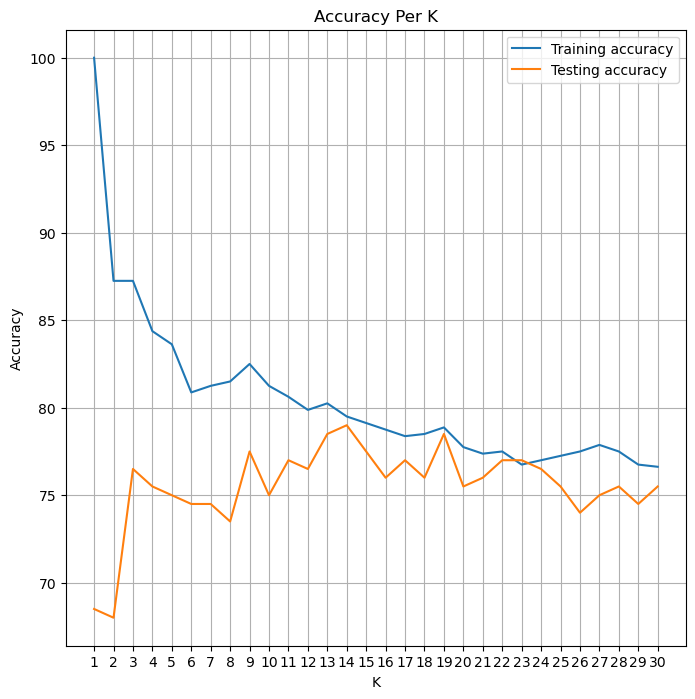

In [11]:
# Plotting the lists
plt.figure(figsize=(8, 8))
plt.plot(range(1,31), KTrainAcc, label='Training accuracy')
plt.plot(range(1,31), KTestAcc, label='Testing accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy Per K')
plt.xticks(range(1,31))
plt.grid()
plt.legend()
plt.show()

**The selection of the optimal k for the KNN model:** The graph below shows how the accuracy of the KNN model changes with different values of k, the number of nearest neighbors.
We chose **K = 14** to be our optimal k for our model.
This is because this value gives us the accuracy of ~0.78, which means that the model correctly predicts 78% of the cases. This value also avoids the problems of underfitting/overfitting that can occur with too small or too large values of K.
Underfitting is when the model is too simple and fails to capture the complexity of the data.
Overfitting is when the model is too complex and memorizes the data, but fails to generalize to new data.
We can see that when k is too small, such as 1 or 2, the accuracy is low, around 0.6 or 0.65.
This means that the model is too sensitive to noise and outliers, and does not consider enough information from other neighbors.
We can also see that when k is too large, such as 25 or 30, the accuracy drops slightly, around 0.7 or 0.72.
This means that the model is too smooth and loses some details and distinctions, and considers too much information from irrelevant neighbors. Therefore, we chose k=10 as a balance between complexity and simplicity, and between noise and smoothness.

**K=3:**

In [12]:
K_3_Train_Accuracy = KTrainAcc[2]
K_3_Train_Accuracy

87.25

In [13]:
K_3_Test_Accuracy = KTestAcc[2]
K_3_Test_Accuracy

76.5

**The drawback of K=3 for the KNN model:** K=3 is a value of k that gives us a good accuracy for our training data, but not a good accuracy for our test data. This means that the model does not generalize well to new data, and may be overfitting.

***

## Part C: LogisticRegression

### 9:

**Sigmoid Function:**

In [14]:
def Sigmoid(x,w):
    XcrossprodW = w[0] + np.sum(x@w[1:])
    if XcrossprodW >= 0:
        #σ = 1/1+z , z = w(transpose)x + w0
        z = np.exp(-XcrossprodW)
        return 1/(1+z)
    else:
        #using identity: 1-σ(z) = σ(-z)
        #doing this keeps numerical accuracy prevents overflow when reaching large exponents.
        z = np.exp(XcrossprodW)
        return z/(1+z)

**Gradient for a specific point**

In [15]:
def gradient(x, y, w):
    probability = Sigmoid(x,w);
    #returns: x*(σ(x,w) - y)
    return x*(probability-y)

**Gradient for a given set**

In [16]:
def gradientStep(XData, YData, w, a):
    sigma = 0;
    for index in range(XData.shape[0]):
        sigma = sigma + gradient(XData[index, :], YData[index], w);
       
    w_tnext = np.concatenate([[w[0]], w[1:] - a*sigma])
    #returns: w_tnext = w_current -a * Σ(x*(σ(x,w) - y))
    return w_tnext

**Accuracy Vector**

In [17]:
def AVec(W, x, y, th):
    AccVec = []
    for n in range(W.shape[0]):
        PC = ProbabilisticLogRegClassifier(W[n], x)
        FC = FinalClassification(PC, th)
        AccVec.append(Accuracy(FC, y))
    return AccVec

**Running the Training Session (Function)**

In [18]:
def RunSim(XData, YData, T, a, w_init):
    #Creates new w vector and puts the current w in the first place
    newW =[]
    newW.append(w_init)
    #Updates w and puts it in the next place in newW vector
    for t in T:
        w_init = gradientStep(XData, YData, w_init, a)
        newW.append(w_init)
    #returns the final optimized w vector    
    return np.array(newW).astype(float)

**Probabilities of all classifications**

In [19]:
def ProbabilisticLogRegClassifier(w, X):
    prob = []
    for i in range(X.shape[0]):
        prob.append(1 / (1 + np.exp(-1*(w[0] + np.sum(np.dot(w[1:],X[i, :]))))))
    return np.array(prob)

**Final Classification:**

In [20]:
def FinalClassification(PC, th):
    Yf = np.zeros((PC.size, ))
    Yf[PC > th] = 1
    return Yf

**Cross Entropy Function:**

In [21]:
def CE(w, x, th,y):
    loss = []
    for n in range(0, w.shape[0]):
        pc = ProbabilisticLogRegClassifier(w[n, :], x)
        loss.append(-1*np.sum(y*np.log(pc)+(1-y)*np.log(1-pc)))
    T = range(0, w.shape[0])
    plt.plot(T, loss)
    plt.xlabel('T')
    plt.ylabel('Cross Entropy (Loss)')
    plt.title('Cross Entropy')
    plt.grid()
    plt.show()
    return loss

**Confusion Matrix Function:**

In [22]:
def confusion_matrix(Y, Y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for y, y_p in zip(Y, Y_pred):
        if y == 1 and y_p == 1:
            TP += 1
        elif y == 0 and y_p == 1:
            FP += 1
        elif y == 0 and y_p == 0:
            TN += 1
        elif y == 1 and y_p == 0:
            FN += 1
    return [[TN, FP], [FN, TP]]

**Plotting the Confusion Matrix:**

In [23]:
def plot_cm(confusion_matrix):
    labels = ['True Positive', 'False Positive', 'False Negative', 'True Negative']
    categories1 = ['Actual Negative','Actual Positive']
    categories2 = ['Predicted Negative','Predicted Positive']
    cm = np.array(confusion_matrix)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(categories1))
    plt.xticks(tick_marks, categories2)
    plt.yticks(tick_marks, categories1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.grid(False)
    width, height = cm.shape
    for i in range(width):
        for j in range(height):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
    plt.show()

**ROC:**

In [24]:
def ROC(pc, Y):
    FPR = []
    TPR = []
    for threshold in np.linspace(1, 0, 11):
        Ypred = FinalClassification(pc, threshold)
        cm = confusion_matrix(Ypred, Y)
        TPR.append(cm[0][0] / (cm[0][0] + cm[1][0]))
        FPR.append(cm[0][1] / (cm[0][1] + cm[1][1]))
    plt.figure(figsize=(8, 8))
    plt.title('ROC')
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.scatter(FPR, TPR, color ='orange')
    plt.plot(FPR, TPR, color='blue')
    plt.grid()
    plt.show()

***

**A) Running the simulation** 

In [25]:
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T = 
T = list(range(300))
#Get final w out of the training
w_final = RunSim(Xtrain, Ytrain, T, 0.00001, w_init)
T = list(range(301))
#Sets default Threshold = 0.5
threshold = 0.5

**A) Printing the Cross-Entropy of the session:**

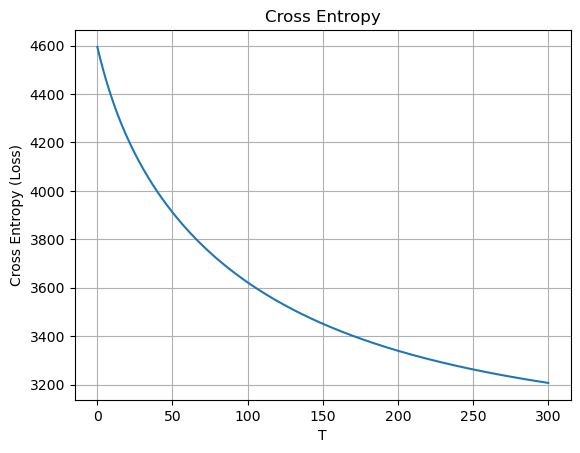

In [26]:
ce = CE(w_final, Xtrain, threshold, Ytrain)

**A) Printing the accuracy for the training session:**

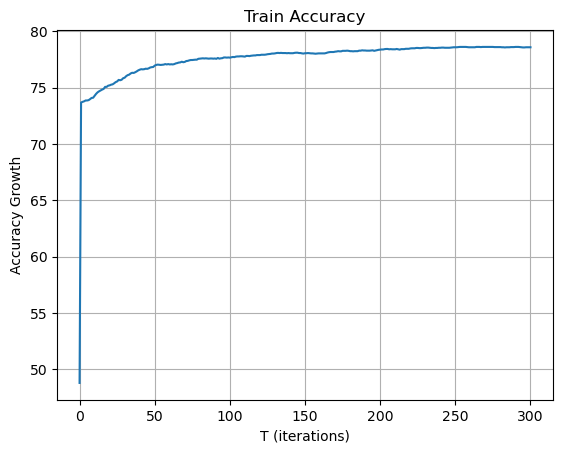

In [27]:
TrainAccuracy = AVec(w_final, Xtrain,Ytrain, threshold)
plt.plot(T,TrainAccuracy)
plt.title("Train Accuracy")
plt.ylabel("Accuracy Growth")
plt.xlabel("T (iterations)")
plt.grid()

**B) Running simulation with Test data:**

In [28]:
#Init w to 0
w_init = np.zeros((Xtest.shape[1]+1))
#Sets default number of iteration T = 
T = list(range(300))
#Get final w out of the training
w_final = RunSim(Xtest, Ytest, T, 0.00001, w_init)
T = list(range(301))
#Sets default Threshold = 0.5
threshold = 0.5

**B) Printing the accuracy for the testing session:**

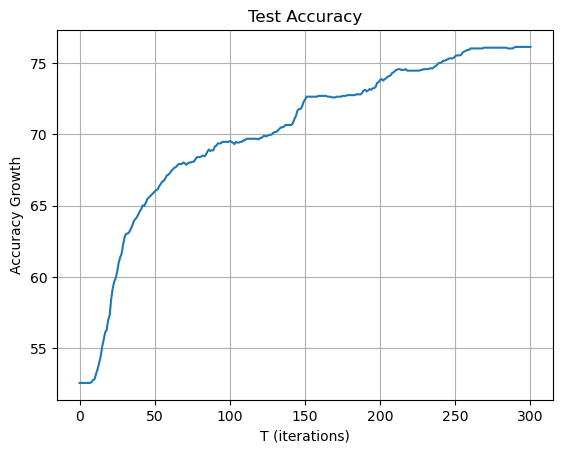

In [29]:
TestAccuracy = AVec(w_final, Xtest,Ytest, threshold)
plt.plot(T,TestAccuracy)
plt.title("Test Accuracy")
plt.ylabel("Accuracy Growth")
plt.xlabel("T (iterations)")
plt.grid()

**C) ROC , Confusion Matrix:**

In [30]:
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T 
T = list(range(301))
#Sets default Threshold = 0.5
threshold = 0.5
p = ProbabilisticLogRegClassifier(w_init, Xtrain)
Yf = FinalClassification(p, threshold)

**Untrained:**

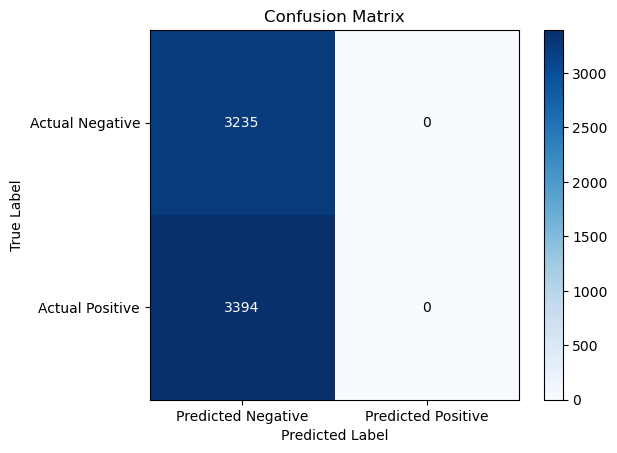

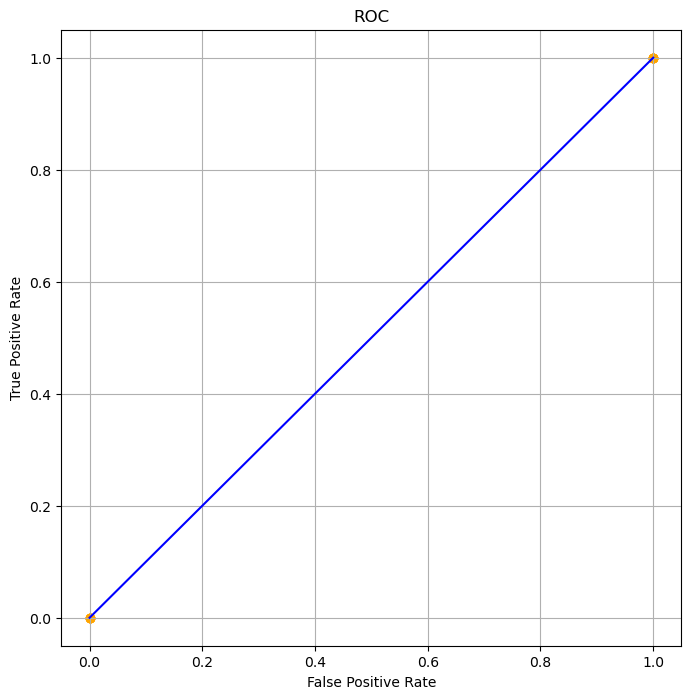

In [31]:
conf_mat = confusion_matrix(Ytrain,Yf)
plot_cm(conf_mat)
ROC(p, Ytrain)

**T/2 Iterations:**

In [32]:
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T 
T_2 = int(len(T)/2) 
#Sets default Threshold = 0.5
threshold = 0.5
p = ProbabilisticLogRegClassifier(w_final[T_2], Xtrain)
Yf = FinalClassification(p, threshold)

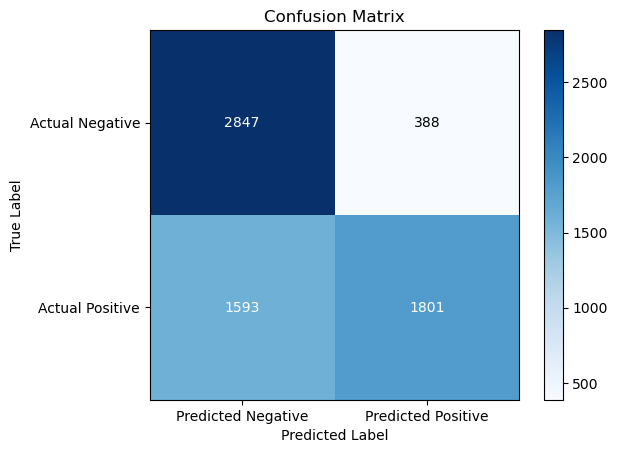

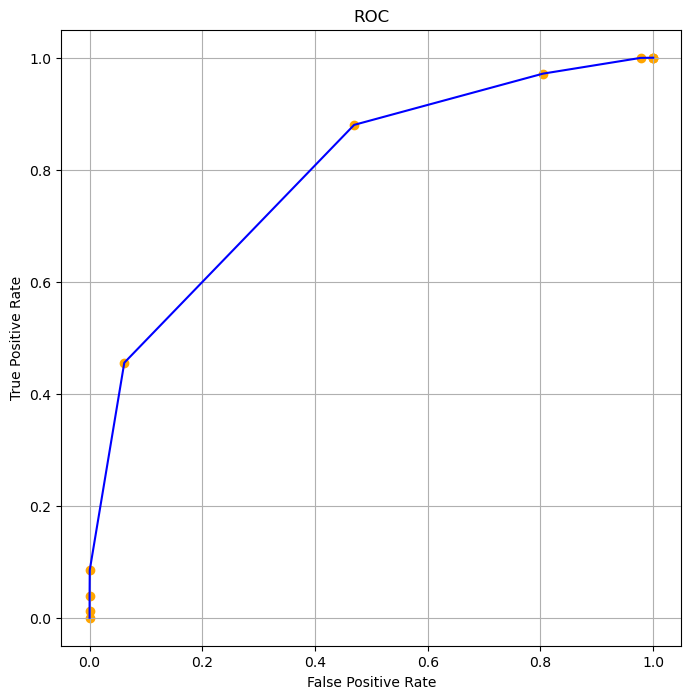

In [33]:
conf_mat = confusion_matrix(Ytrain,Yf)
plot_cm(conf_mat)
ROC(p, Ytrain)

**T Iterations:**

In [34]:
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T
T = list(range(300))
T_final = w_final.shape[0]-1 
#Sets default Threshold = 0.5
threshold = 0.5
p = ProbabilisticLogRegClassifier(w_final[T_final], Xtrain)
Yf = FinalClassification(p, threshold)

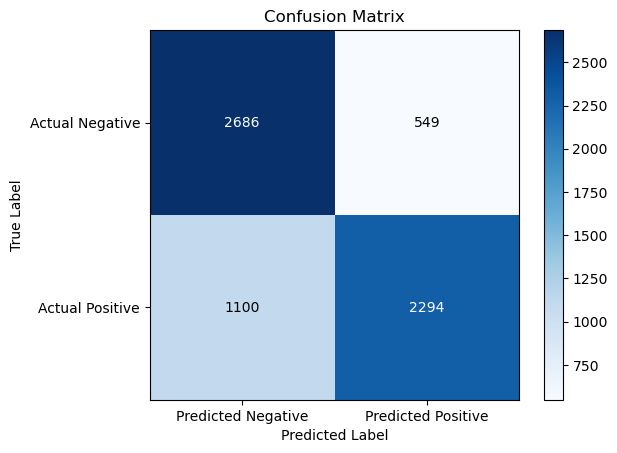

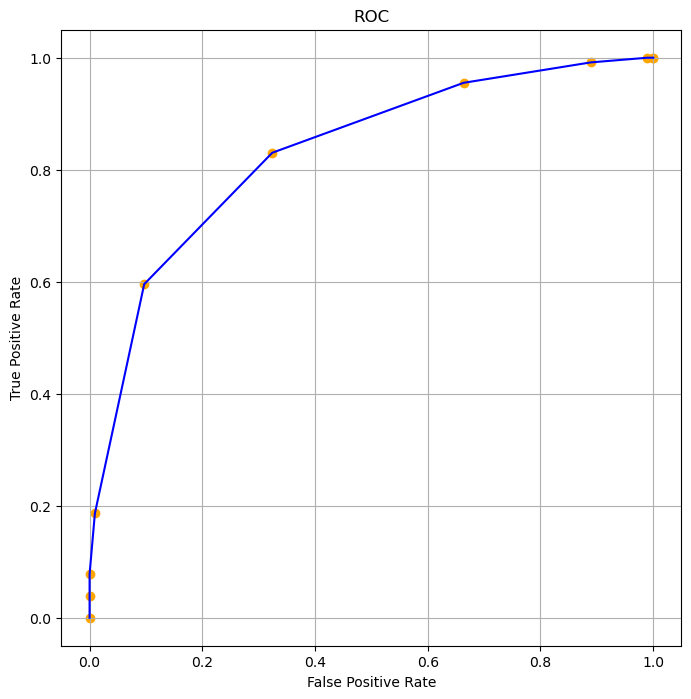

In [35]:
conf_mat = confusion_matrix(Ytrain,Yf)
plot_cm(conf_mat)
ROC(p, Ytrain)

**D) Test Data:**

In [36]:
#Init w to 0
w_init = np.zeros((Xtest.shape[1]+1))
#Sets default number of iteration T
T = list(range(300))
T_final = w_final.shape[0]-1 
#Sets default Threshold = 0.5
threshold = 0.5
p = ProbabilisticLogRegClassifier(w_final[T_final], Xtest)
Yf = FinalClassification(p, threshold)

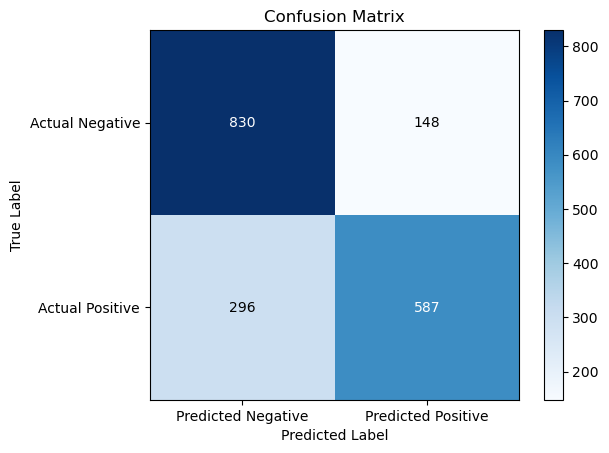

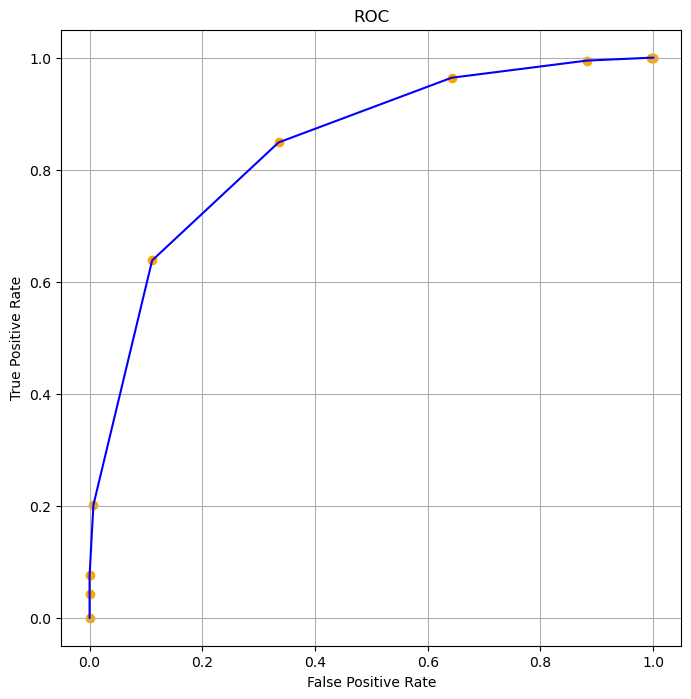

In [37]:
conf_mat = confusion_matrix(Ytest,Yf)
plot_cm(conf_mat)
ROC(p, Ytest)

In [38]:
TestAccuracy = AVec(w_final, Xtest, Ytest, threshold)

In [39]:
TestAccuracy

[52.55239118753359,
 52.55239118753359,
 52.55239118753359,
 52.55239118753359,
 52.55239118753359,
 52.55239118753359,
 52.55239118753359,
 52.55239118753359,
 52.60612573885008,
 52.76732939279957,
 52.82106394411606,
 53.197205803331535,
 53.51961311123053,
 53.949489521762494,
 54.37936593229446,
 55.077915099408926,
 55.561526061257396,
 56.09887157442235,
 56.26007522837184,
 56.958624395486304,
 57.281031703385274,
 58.409457281031706,
 59.16174099946265,
 59.64535196131112,
 59.91402471789361,
 60.34390112842558,
 60.98871574422353,
 61.36485760343901,
 61.633530360021496,
 62.27834497581946,
 62.81569048898442,
 63.0306286942504,
 63.0306286942504,
 63.1380977968834,
 63.35303600214937,
 63.56797420741537,
 63.890381515314346,
 64.05158516926383,
 64.15905427189684,
 64.37399247716282,
 64.5889306824288,
 64.7501343363783,
 65.01880709296077,
 64.96507254164428,
 65.18001074691027,
 65.44868350349275,
 65.55615260612574,
 65.66362170875874,
 65.77109081139173,
 65.878559914024

***

### 10:

**A:**

**Choosing T**: Choosing the optimal “T”, The number of iterations, is a crucial parameter for our model’s training.
If we set “T” too low, we risk interrupting the learning process before reaching the best possible accuracy.
If we set “T” too high, we waste time and resources without improving the accuracy significantly.
Therefore, we need to find the optimal “T” that maximizes the accuracy and minimizes the resource consumption.
We can do this by looking at the Cross-Entropy chart, which shows how the accuracy changes with different values of “T”. Based on the chart, we chose “T” to be 300. This value gives us an accuracy of over 77%, and does not consume too much resources.

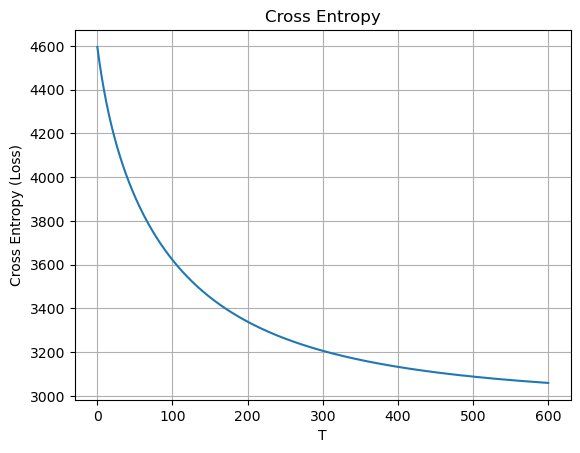

In [40]:
#First, we try a large T that shows us that the graph is coverging to a low value after many iterations.
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T = 
T = list(range(600))
#Get final w out of the training
w_final = RunSim(Xtrain, Ytrain, T, 0.00001, w_init)
T = list(range(601))
#Sets default Threshold = 0.5
threshold = 0.5
ce = CE(w_final, Xtrain, threshold, Ytrain)

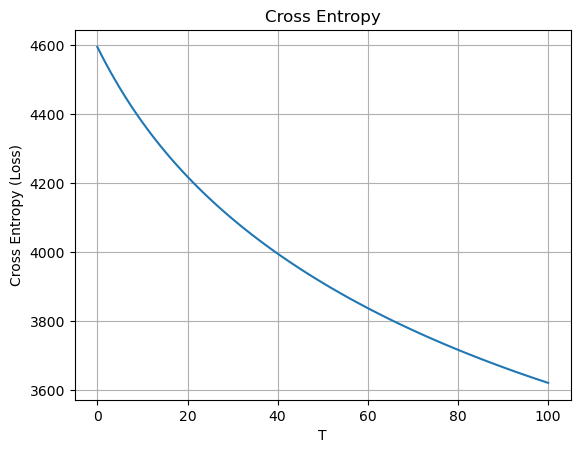

In [41]:
#First, we try a small T that shows us that the graph is stopping in the middle of the training -
#- the accuracy can still improve.
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T = 
T = list(range(100))
#Get final w out of the training
w_final = RunSim(Xtrain, Ytrain, T, 0.00001, w_init)
T = list(range(101))
#Sets default Threshold = 0.5
threshold = 0.5
ce = CE(w_final, Xtrain, threshold, Ytrain)

After some trial and error, this is what led us to choose **T = 300 iterations.**

**B:**

**Choosing the optimal alpha:** Alpha is the parameter that determines the size of the steps that the model takes in each iteration to update the W values and improve the accuracy.
The value of alpha affects how fast and how well the model converges to the optimal solution.
If alpha is too large, the model may overshoot the optimal point and oscillate around it, resulting in poor accuracy.
If alpha is too small, the model may take very small steps and converge very slowly, wasting time and resources. Therefore, we need to find the optimal alpha that balances the speed and quality of convergence. We can do this by experimenting with different values of alpha and observing how they affect the accuracy and the W values.
Based on our experiments, we chose alpha to be ------. This value allows the model to converge quickly and reliably to a high accuracy.

In [42]:
#First, we try a large T that shows us that the graph is coverging to a low value after many iterations.
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T = 
T = list(range(300))
#Get final w out of the training
w_final = RunSim(Xtrain, Ytrain, T, 0.1, w_init)
T = list(range(301))
#Sets default Threshold = 0.5
threshold = 0.5

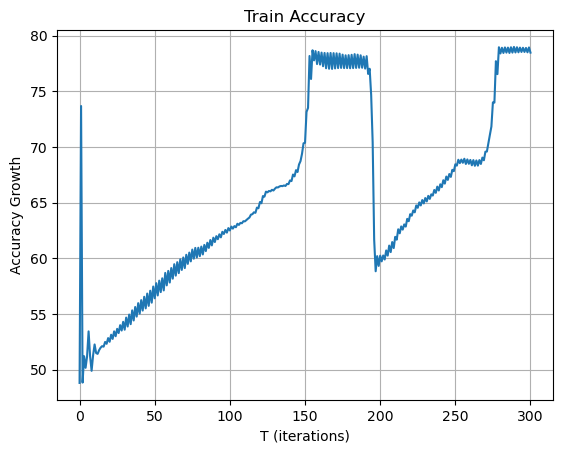

In [43]:
#plotting results, with alpha = 0.1:
TrainAccuracy = AVec(w_final, Xtrain,Ytrain, threshold)
plt.plot(T,TrainAccuracy)
plt.title("Train Accuracy")
plt.ylabel("Accuracy Growth")
plt.xlabel("T (iterations)")
plt.grid()

In [44]:
#First, we try a large T that shows us that the graph is coverging to a low value after many iterations.
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T = 
T = list(range(300))
#Get final w out of the training
w_final = RunSim(Xtrain, Ytrain, T, 0.0000000001, w_init)
T = list(range(301))
#Sets default Threshold = 0.5
threshold = 0.5

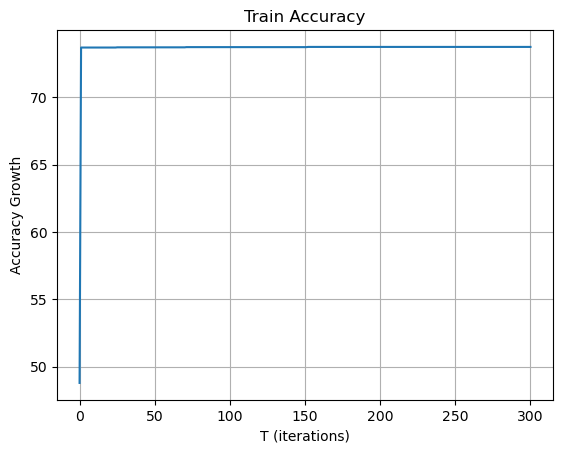

In [45]:
#plotting results, with alpha = 0.0000000001:
TrainAccuracy = AVec(w_final, Xtrain,Ytrain, threshold)
plt.plot(T,TrainAccuracy)
plt.title("Train Accuracy")
plt.ylabel("Accuracy Growth")
plt.xlabel("T (iterations)")
plt.grid()

After some trial and error, this is what led us to choose **alpha = 0.00001.**

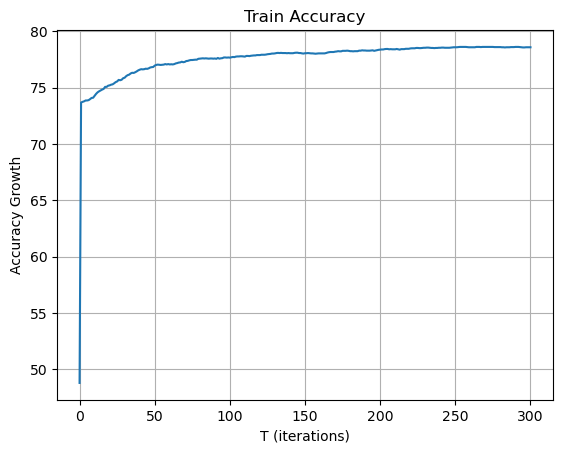

In [46]:
#First, we try a large T that shows us that the graph is coverging to a low value after many iterations.
#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))
#Sets default number of iteration T = 
T = list(range(300))
#Get final w out of the training
w_final = RunSim(Xtrain, Ytrain, T, 0.00001, w_init)
T = list(range(301))
#Sets default Threshold = 0.5
threshold = 0.5

#plotting results, with our alpha (0.00001):
TrainAccuracy = AVec(w_final, Xtrain,Ytrain, threshold)
plt.plot(T,TrainAccuracy)
plt.title("Train Accuracy")
plt.ylabel("Accuracy Growth")
plt.xlabel("T (iterations)")
plt.grid()

**B:**

**The relationship between alpha and T:** Alpha and T have an inverse relationship - the higher the number of iterations, the smaller the steps we need to take, and vice versa.
This is because the more iterations we do, the closer we get to the optimal point, and the smaller the adjustments we need to make. On the other hand, the fewer iterations we do, the farther we are from the optimal point, and the larger the steps we need to take to get there.
Therefore, we need to choose alpha and T in a way that they complement each other and help the model converge efficiently and effectively.

**C:**

**The effect of w_init on the model’s iteration number and stop point**: w_init is the initial value of the W vector that the model starts with. The value of **w_init** affects how far the model is from the optimal point at the beginning of the training.<br>
If **w_init** is close to the optimal point, the model will need fewer iterations to converge and will stop at a point that has a high accuracy.<br>
If **w_init** is far from the optimal point, the model will need more iterations to converge and may stop at a point that has a low accuracy.<br>
Therefore, we need to choose **w_init** carefully to avoid wasting time and resources or getting poor results. In our case, we chose w_init randomly as “0” in all its values.

**D:**

**The effect of data splitting on the training:** Data splitting is the process of dividing the data into two or more subsets, such as training, validation, and test sets. 
Data splitting is useful for evaluating the performance of the model on unseen data and avoiding overfitting or underfitting. However, data splitting also reduces the amount of data available for training, which may affect the accuracy of the model.
Therefore, we need to find the optimal way to split the data that balances the trade-off between training and evaluation. In our case, we did not split the data more than once and it was not needed. This is because our data was large and diverse enough to train and test the model without losing any information or introducing any bias. We can verify this by comparing our results with different ways of splitting the data to see how they differ.

**E + F:**

**The rationale for data splitting:** We decided to split our data into a 80/20 ratio (training/testing). This gave us a sufficient number of examples for the model to learn from, without causing overfitting. Overfitting is when the model memorizes the training data, but fails to generalize to new data. After reviewing the results of the training, we found that the training accuracy was consistent with the testing accuracy. This means that the model was able to perform well on both the data that it learned from and the data that it had not seen before.
We decided not to split the data in any other way.


***

## Part D: LogisticRegression, the effect of normalizing the data:

### 11:

In [47]:
Ytrain = np.array(Data["Transported"].loc[:np.round(0.8*DFlen)])
Xtrain = np.array(Data.drop("Transported", axis=1).loc[:np.round(0.8*DFlen)])

#Reassigning Xtrain, Xtest, Ytrain,Ytest - to prevent any technical issues.
Ytest = np.array(Data["Transported"].loc[np.round(0.8*DFlen):])
Xtest = np.array(Data.drop("Transported", axis=1).loc[np.round(0.8*DFlen):])

In [48]:
#calculate the mean of each column in Xtest
Xtest_mean = np.mean(Xtest, axis=0)

#calculate the standard deviation of each column in Xtest
Xtest_std = np.std(Xtest, axis=0)

#calculate the mean of each column in Xtrain
Xtrain_mean = np.mean(Xtrain, axis=0)

#calculate the standard deviation of each column in Xtrain
Xtrain_std = np.std(Xtrain, axis=0)

#subtract the mean and divide by the standard deviation for Xtrain
Xtrain = np.divide(np.subtract(Xtrain, Xtrain_mean), Xtrain_std)

#subtract the mean and divide by the standard deviation for Xtest
Xtest = np.divide(np.subtract(Xtest, Xtest_mean), Xtest_std)

In [49]:
#Due to long runtimes, to debug and test if things work we took less values
DebugXTrain = Xtrain[:800]
DebugXTest = Xtest[:200]
DebugYTrain = Ytrain[:800]
DebugYTest = Ytest[:200]

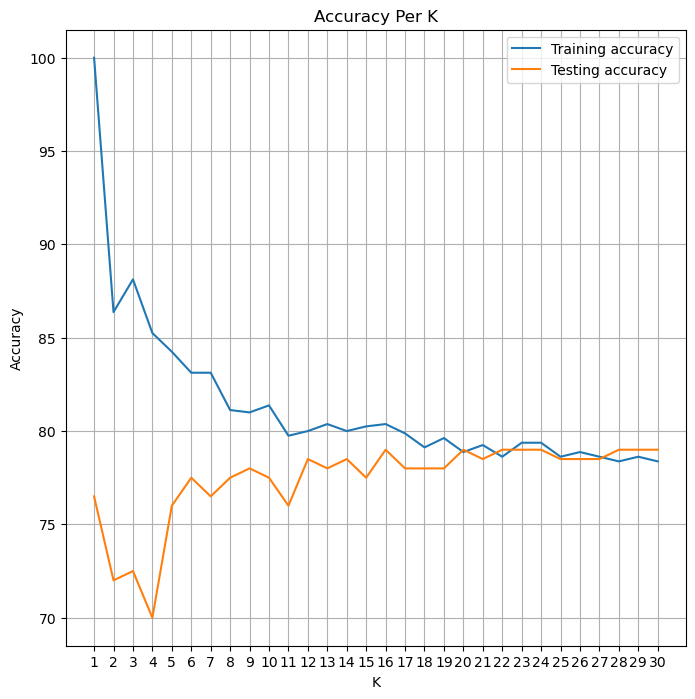

In [50]:
#Testing different "K"s in the range of 1-30
KTrainAcc = []
KTestAcc = []
for K in range(1,31):
    KTrainAcc.append(Accuracy(KNNFullRun(K,DebugXTrain,DebugYTrain, DebugXTrain), DebugYTrain))
    KTestAcc.append(Accuracy(KNNFullRun(K,DebugXTrain,DebugYTrain, DebugXTest), DebugYTest))
    
# Plotting the lists
plt.figure(figsize=(8, 8))
plt.plot(range(1,31), KTrainAcc, label='Training accuracy')
plt.plot(range(1,31), KTestAcc, label='Testing accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy Per K')
plt.xticks(range(1,31))
plt.grid()
plt.legend()
plt.show()

**A:** 

The data did not require any modifications and the training sessions of our models were identical.

**B:** 

**The new accuracy graph of the normalized data** shows higher values than the graph of the non-normalized data, which indicates an improvement in the performance of the KNN algorithm.<br>
The peak accuracy of the normalized data is also the same as the asymptotic accuracy of the non-normalized data, which suggests that the normalization process has accelerated the convergence of the algorithm.

**The optimal K for this scenario** is K=16, as shown by the graph, which is different from the previous graph (Optimal K was K=14).

**Yes, there was a difference between the accuracies of the normalized and non-normalized data.**<br> 
The normalized data had higher accuracy values than the non-normalized data, which means that the KNN classifier performed better with the normalized data.

**Some possible reasons for this difference are:**<br>
Normalization helps to reduce the range and variance of the features, which can improve the distance calculation and the nearest neighbor selection in KNN. When the scale of features is very different, one feature will dominate the distance calculation, leading KNN to rely more on that feature than others.<br>

Normalization ensures that all features are mapped to the same range of values, so that KNN can give equal importance to all features.<br>

Normalization can also help to reduce the effect of outliers and noise on the features, which can improve the quality and reliability of the data. Outliers and noise can distort the distance calculation and the nearest neighbor selection in KNN, leading to incorrect classification.<br>

Normalization can help to minimize their impact by bringing them closer to the mean or median of the features.<br>

Normalization can also help to balance the scales and weights of the features, which can prevent some features from dominating or overshadowing others in the KNN model. Some features may have more influence on the classification outcome than others, depending on their relevance and significance. Normalization can help to adjust their weights by scaling them according to their standard deviation or variance.

***

**LogisticRegression:**

In [51]:
#Training data:

#Init w to 0
w_init = np.zeros((Xtrain.shape[1]+1))

#Sets default number of iteration T = 
T = list(range(300))

#Get final w out of the training
w_final = RunSim(Xtrain, Ytrain, T, 0.00001, w_init)
T = list(range(301))

#Sets default Threshold = 0.5
threshold = 0.5

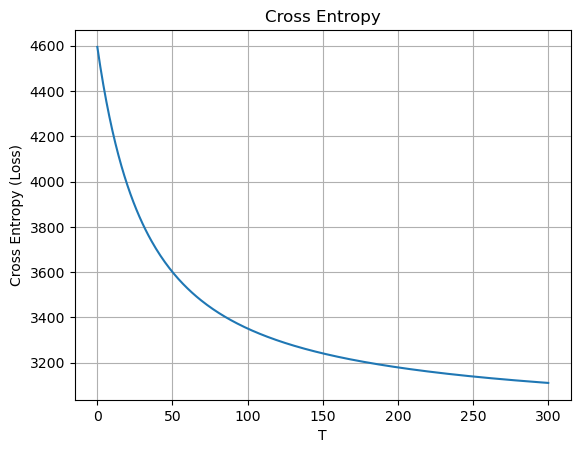

In [52]:
#Cross Entropy: 
ce = CE(w_final, Xtrain, threshold, Ytrain)

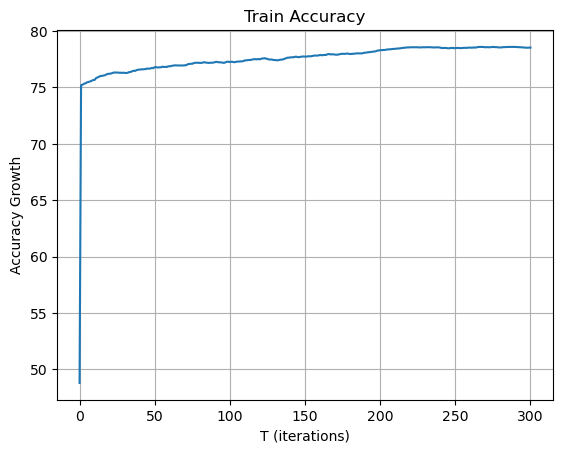

In [53]:
#Accuracy:
TrainAccuracy = AVec(w_final, Xtrain,Ytrain, threshold)
plt.plot(T,TrainAccuracy)
plt.title("Train Accuracy")
plt.ylabel("Accuracy Growth")
plt.xlabel("T (iterations)")
plt.grid()

In [54]:
#Testing data:

#Init w to 0
w_init = np.zeros((Xtest.shape[1]+1))

#Sets default number of iteration T = 
T = list(range(300))

#Get final w out of the training
w_final = RunSim(Xtest, Ytest, T, 0.00001, w_init)
T = list(range(301))

#Sets default Threshold = 0.5
threshold = 0.5

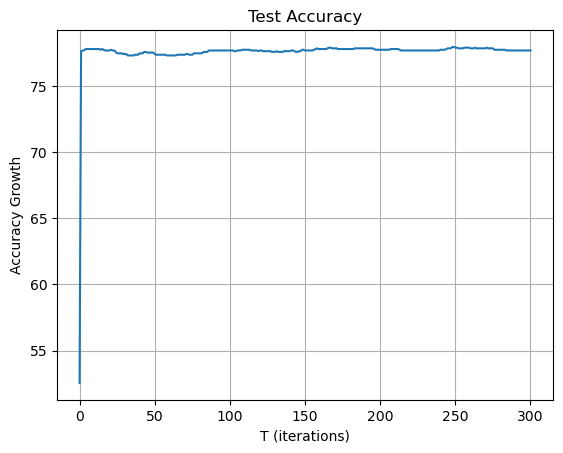

In [55]:
#Accuracy:
TestAccuracy = AVec(w_final, Xtest,Ytest, threshold)
plt.plot(T,TestAccuracy)
plt.title("Test Accuracy")
plt.ylabel("Accuracy Growth")
plt.xlabel("T (iterations)")
plt.grid()

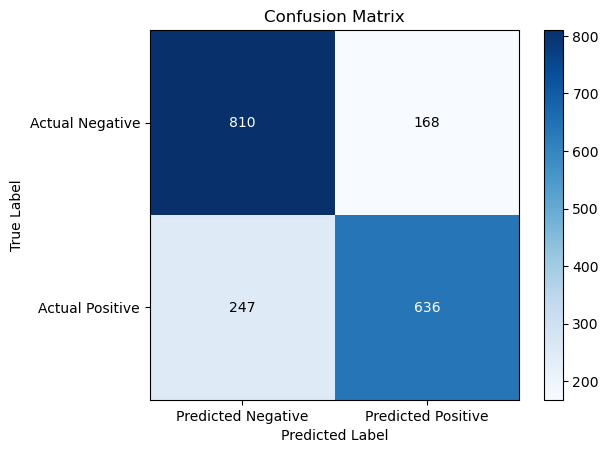

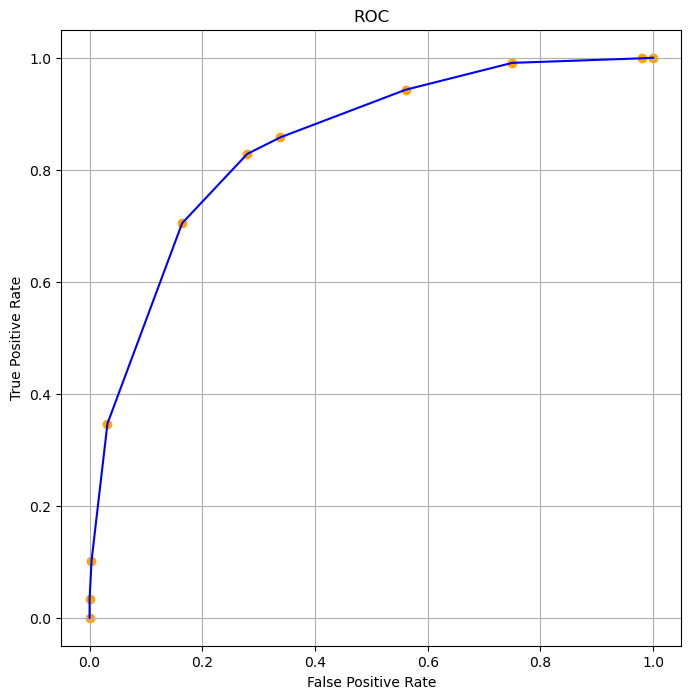

In [56]:
#ROC and Confusion Matrix
p = ProbabilisticLogRegClassifier(w_final[T_final], Xtest)
Yf = FinalClassification(p, threshold)
conf_mat = confusion_matrix(Ytest,Yf)
plot_cm(conf_mat)
ROC(p, Ytest)

**A:** 

The data did not require any modifications and the training sessions of our models were identical.

**B:** 

**The accuracy graph of the normalized data** has higher values than the one of the non-normalized data, which means that the LogisticRegression algorithm performs better with the normalized data. The normalized data also reaches the same peak accuracy as the non-normalized data, but faster, which implies that the normalization process helps the algorithm converge quicker.

**Yes, there was a difference between the accuracies of the normalized and non-normalized data.**<br>
The normalized data had higher accuracy values than the non-normalized data, which means that the logistic regression classifier performed better with the normalized data.<br>

**Some possible reasons for this difference are:**<br>
Normalization helps to reduce the range and variance of the features, which can improve the convergence and stability of the logistic regression algorithm.
Normalization can also help to reduce the effect of outliers and noise on the features, which can improve the quality and reliability of the data.<br>
Normalization can also help to balance the scales and weights of the features, which can prevent some features from dominating or overshadowing others in the logistic regression model.<br>